Link to the dataset [Red Wine Data](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009 "Red Wine Data").

If some plots are not displayed, take a look through nbviewer [Link to Notebook](https://nbviewer.org/github/eugbutski/ds-projects/blob/b6385c80322bc8177eb369a14a8854ccf40fdf23/wine_quality/wine_quality.ipynb "Link to Notebook").

# imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from sklearn.neural_network import MLPClassifier

# for optimizing hyperparameters of the best model
import optuna

# for training and testing neural network
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

# Some additional useful imports
from collections import defaultdict
from time import perf_counter
#import logging

In [53]:
wine_qual = pd.read_csv('dataset/winequality-red.csv')
wine_qual.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# 1. Exploratory analysis

In [3]:
wine_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


There are 1599 entries in following dataset and presented only numerical features.

In [4]:
#sns.pairplot(wine_qual, hue='quality')

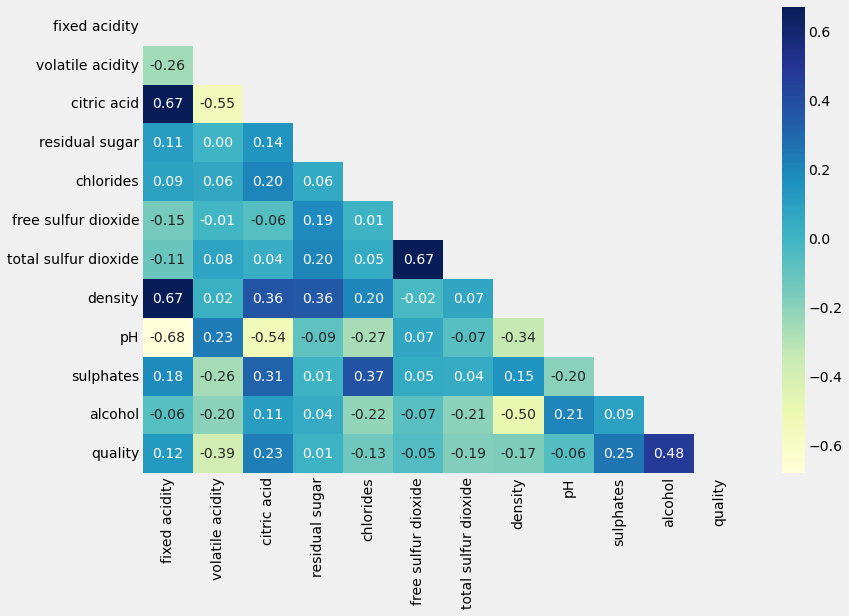

In [4]:
# Correlation matrix
correlation = wine_qual.corr()
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

with plt.style.context('fivethirtyeight'):
    figure = plt.figure(figsize=(12, 8))
    sns.heatmap(correlation, annot=True, mask=mask, fmt=".2f", cmap="YlGnBu")

It can be seen, that there is a from high to very high correlation, as well as a negative one between different type of accidity. Additionaly, fixed accidity correlates very strong with a density, whereas density correlates relatively strong with citric acid and residual sugar. Prety high correlation with target variable (quality) are demostrating alchohol (0.48), sulphates (0.25), citric acid (0.23) nad volatile acidity (-0.39), etc. 

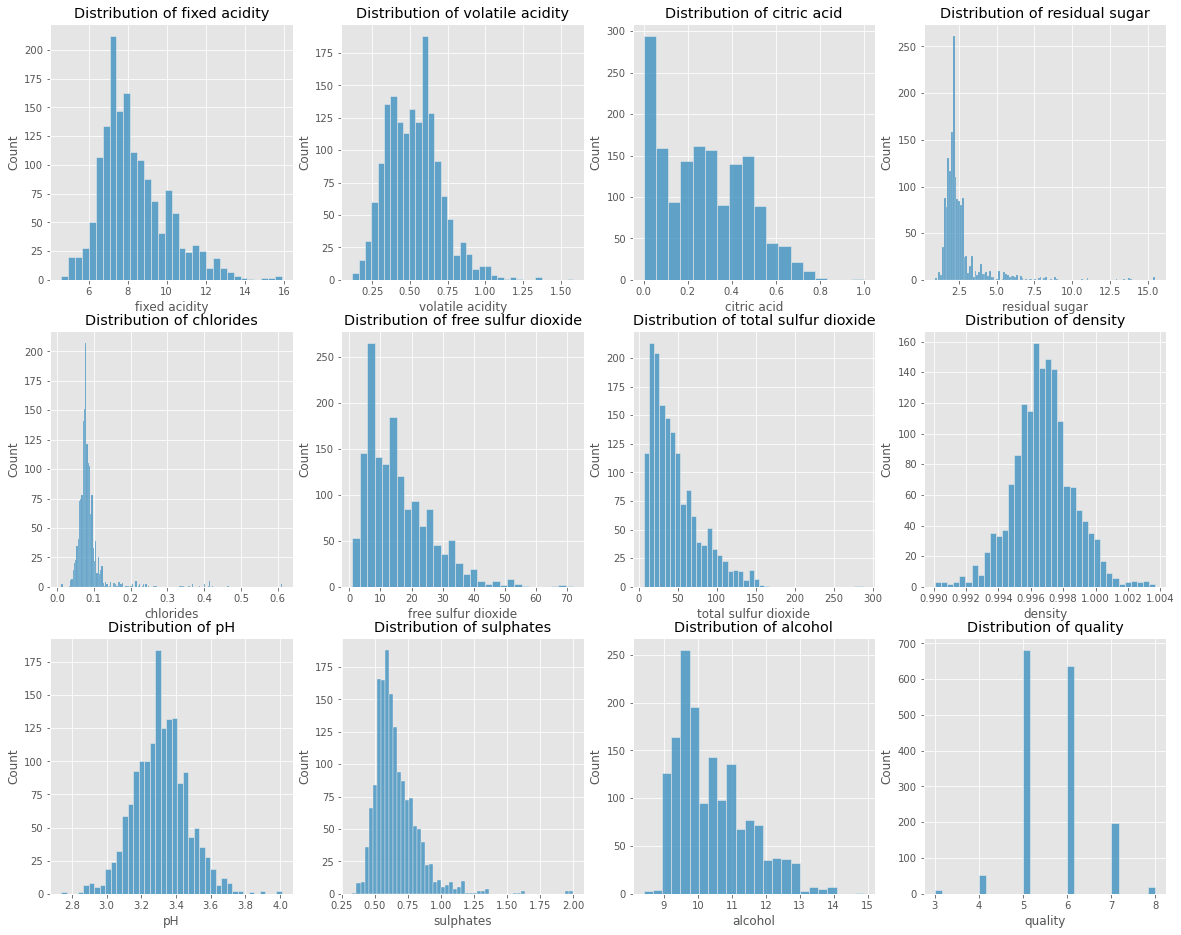

In [5]:
# Distribution plot of all variables, inclusively target variable
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(20, 16))
    for i, col in enumerate(wine_qual.columns, 1):
        plt.subplot(3, 4, i)
        sns.histplot(wine_qual[col]).set_title(f"Distribution of {col}")

According to the distribution plot, some of the variables are tending to have a normal type of distribution (like pH and density), some of the variables are slightly skewed (volatile and fixed acidity, etc.). Thus, this would be a good choice to normalize/standardize the variables

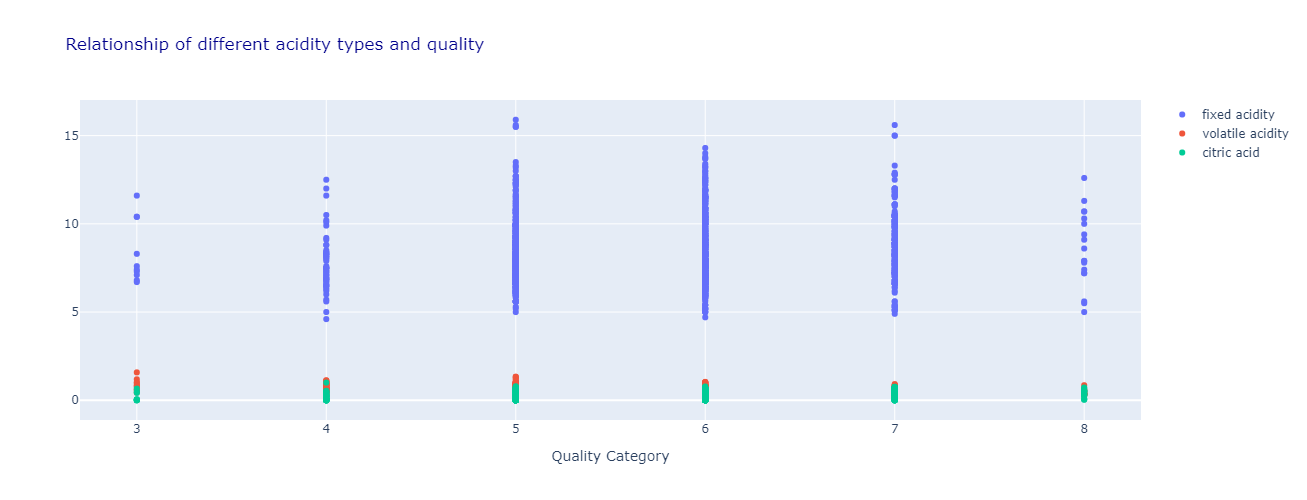

In [60]:
# Scatter plot
fig = go.Figure([go.Scatter(y=wine_qual['fixed acidity'], x=wine_qual['quality'], mode='markers', name='fixed acidity'),
                go.Scatter(y=wine_qual['volatile acidity'], x=wine_qual['quality'], mode='markers', name='volatile acidity'),
                go.Scatter(y=wine_qual['citric acid'], x=wine_qual['quality'], mode='markers', name='citric acid')
                ])

fig.update_xaxes(title_text='Quality Category')

fig.update_layout(
    autosize=False,
    width=700,
    height=500,
    title_font_color="darkblue",
    title_text='Relationship of different acidity types and quality')
fig.show()

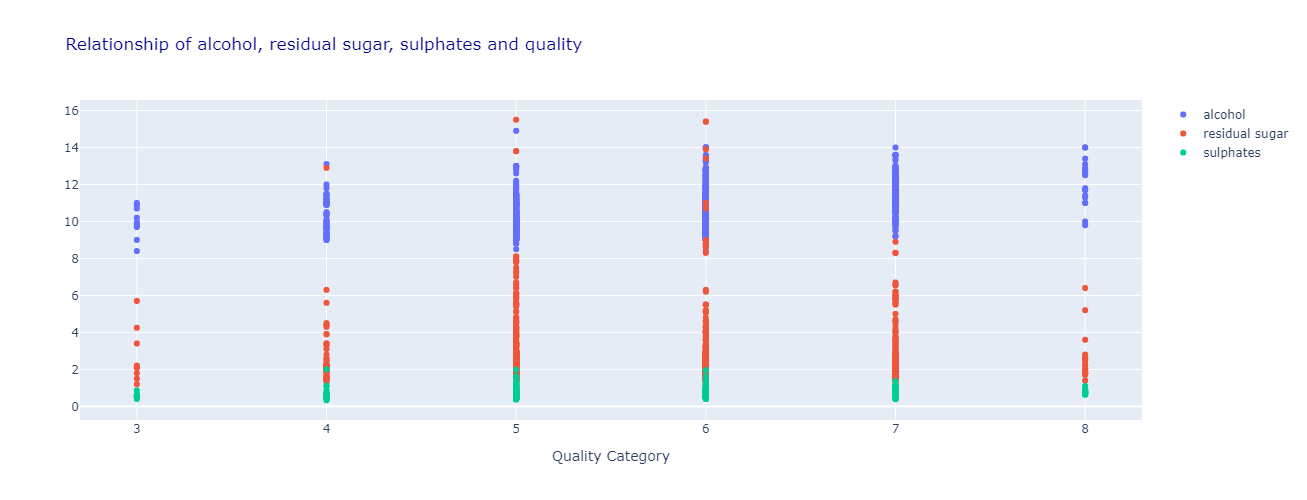

In [61]:
fig = go.Figure([go.Scatter(y=wine_qual['alcohol'], x=wine_qual['quality'], mode='markers', name='alcohol'),
                 go.Scatter(y=wine_qual['residual sugar'], x=wine_qual['quality'], mode='markers', name='residual sugar'),
                 go.Scatter(y=wine_qual['sulphates'], x=wine_qual['quality'], mode='markers', name='sulphates')
                ])

fig.update_xaxes(title_text='Quality Category')

fig.update_layout(
    autosize=False,
    width=700,
    height=500,
    title_font_color="darkblue",
    title_text='Relationship of alcohol, residual sugar, sulphates and quality')
fig.show()

In [8]:
columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
           'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
           'pH', 'sulphates', 'alcohol']

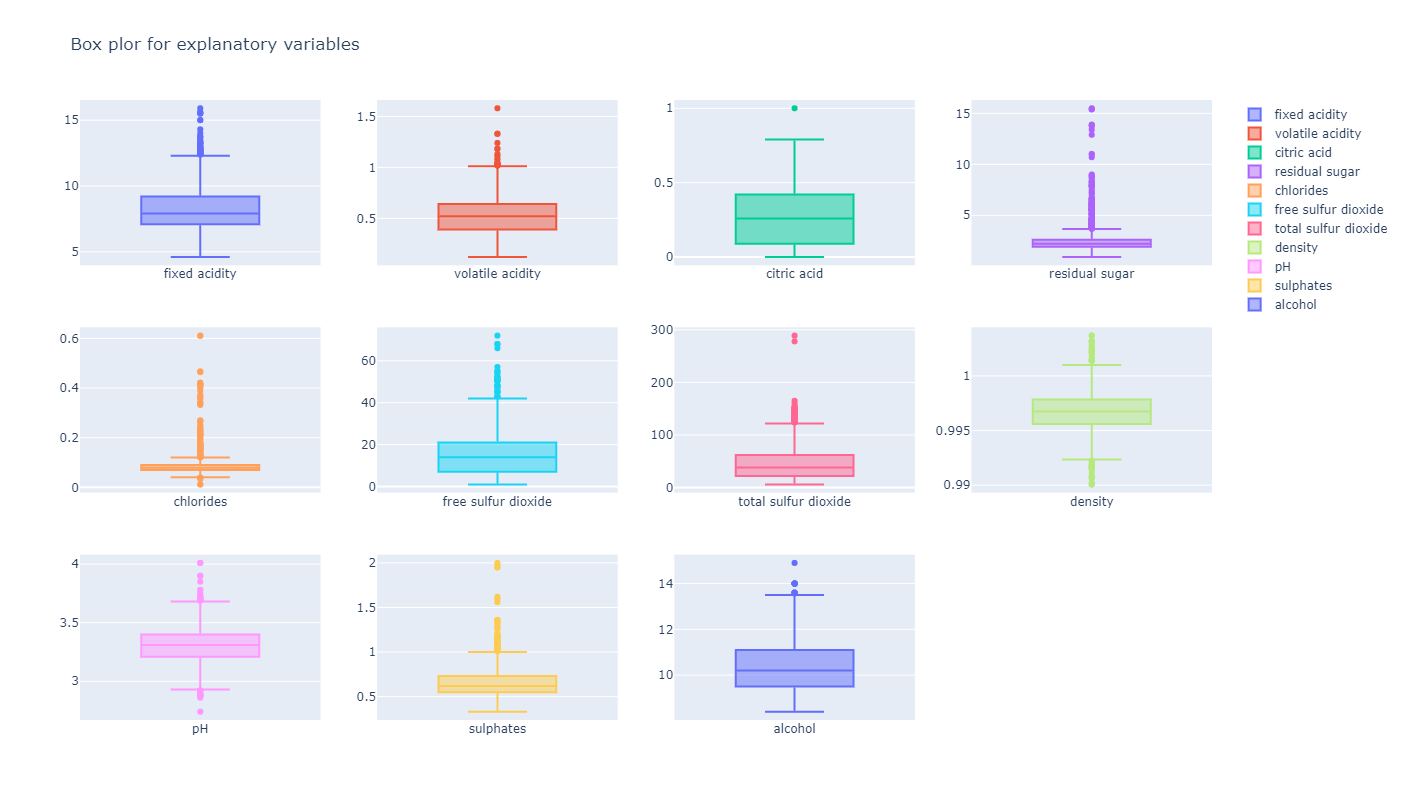

In [55]:
# creating subplots for representing all box plots at one figure
fig = make_subplots(rows=3, cols=4)
row = 1
col = 1

for column, name in zip(wine_qual[columns], columns):
    fig.add_trace(go.Box(y=wine_qual[column], name=name), row=row, col=col)
    # for moving columnwise first and placing each plot in a different slot
    col += 1
    if col > 4:
        col = 1
        row += 1
    if row > 3:
        break

fig.update_layout(
    autosize=False,
    width=900,
    height=800,
    title_text='Box plot for explanatory variables')
fig.show()

Some variables such as residula sugar, free sulfur dioxide and total sulfur dioxide, etc. are having very big amount of outliers and morevoer these are much higher than mean value, thus it could affect the future model. 

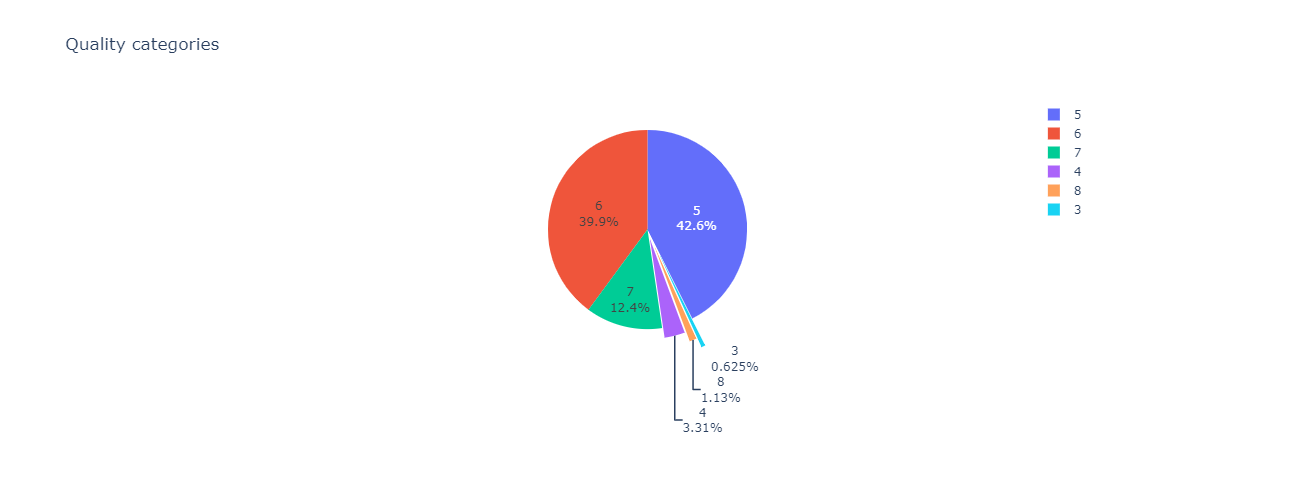

In [21]:
# Pie plot for target variable
fig = go.Figure(data=[go.Pie(labels=wine_qual.quality.value_counts().index,
                             values=wine_qual.quality.value_counts(),
                             textinfo='label+percent',
                             pull=[0, 0, 0, 0.1, 0.2, 0.3])])
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    title_text='Quality categories')
fig.show()

Our target variable represents literally 6 classes/categories, but they are not balanced It could be much better to transform it, such that class distribution would be mor balanced, thus the transformation allows to get a higher predictive power for models and yield better results overall. Let's transform target variable into 2 classes: wine with score less than 6 gets the class 0 and with score higher than or equal 6 the class 1

# 2. Model building and evaluating

In [31]:
# Initializing some constants
SEED = 147
SPLIT_RATIO = 0.25
EPOCHS = 5

In [32]:
def prepare_data(df):
    """
    Creates a target variable from column quality. All wines with quality higher than 5 belongs to class 1, else to 0;
    Scales the data with Standard Scaler from sklearn package, splits the data into train and testing sets.

    Args:
        df (pd.DataFrame): dataframe to be pre-processed

    Returns:
        X (pd.DataFrame): datdaframe with all features
        X_train (pd.DataFrame): training set with all features
        X_test (pd.DataFrame): testing set with all features
        y (np.ndarray): all target variables
        y_train (np.ndarray):  target variables for training set
        y_test (np.ndarray): target variables for testing set
    """
    # transofrm target variable such that we have only 2 classes
    df['target'] = df.quality.apply(lambda x: 1 if x > 5 else 0)
    X = df.drop(['quality', 'target'], axis=1)
    y = df.target
    # normalize the data
    std_scaler = StandardScaler()
    X = std_scaler.fit_transform(X)
    # split the data into training and testing blocks
    X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=SPLIT_RATIO, random_state=SEED)
    # could have been used stratify=df['target'] in order to make same class proportion in test set
    return (X, y.values, X_train, X_test, y_train, y_test)

In [33]:
# load the data
X, y, X_train, X_test, y_train, y_test = prepare_data(wine_qual)

In [34]:
# creating a list of models, which could be used for testing
models = [('log_reg', LogisticRegression(random_state=SEED)),
          ('svm', SVC(random_state=SEED)),
          ('knn', KNeighborsClassifier(n_neighbors=7)),
          ('dt', DecisionTreeClassifier(random_state=SEED)),
          ('histgb', HistGradientBoostingClassifier(random_state=SEED)),
          ('rf', RandomForestClassifier(random_state=SEED)),
          ('adaboost', AdaBoostClassifier(random_state=SEED)),
          ('xgboost', XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='error')),
          ('lgbm', LGBMClassifier(random_state=SEED))]
          #('mlp', MLPClassifier(random_state=SEED))

In [35]:
# Create a dictionary with model names in order to append them to results of the cross-validation 
names = [name[0] for name in models]
names_dict = {}
if "model_name" in names_dict:
    names_dict["model_name"].append(names)
else:
    names_dict["model_name"] = names

In [36]:
def cross_validation(X, y, cv=5):
    """
    Training pipeline for compairing all models in the list from above,
    using the 5-fold cross-validation by-default.
    For comparison are used Accuracy, macro-F1 and ROC-AUC

    Args:
        X (pd.DataFrame): full dataframe of features
        y (np.ndarray): all target variables
        cv (int): number of k-folds for cross-validation. Default is 5.

    Returns:
        results : dictionary with metrics and execution time for each model 
    """   
    
    # creating defaultdict from default collections module in order to append results of CV-procedure
    results = defaultdict(list)
    
    for name, model in models:
        print(f'{name} is being trained and evaluated now...')
        start_time = perf_counter()
        cv_results = cross_validate(model, X, y, cv=cv,
                                    scoring=['f1_macro', 'accuracy', 'roc_auc'])
        end_time = perf_counter()
        training_time = end_time - start_time
        print(f'Finished in {training_time:.3f} sec')
        # calculating mean of 5-folds cv and appending together with training time to the dictionary
        accuracy = cv_results['test_accuracy'].mean()
        f1_score = cv_results['test_f1_macro'].mean()
        auc_score = cv_results['test_roc_auc'].mean()
        results["taken_time"].append(training_time)
        results["Accuracy"].append(accuracy)
        results["f1"].append(f1_score)
        results["AUC"].append(auc_score)
    return results

In [37]:
cv_res = cross_validation(X, y, cv=5) #cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
results_dict = dict(**names_dict, **cv_res)
# Creating dataset from the results dictionary
results_df = pd.DataFrame(data=results_dict)
results_df

log_reg is being trained and evaluated now...
Finished in 0.039 sec
svm is being trained and evaluated now...
Finished in 0.421 sec
knn is being trained and evaluated now...
Finished in 0.124 sec
dt is being trained and evaluated now...
Finished in 0.035 sec
histgb is being trained and evaluated now...
Finished in 1.402 sec
rf is being trained and evaluated now...
Finished in 1.015 sec
adaboost is being trained and evaluated now...
Finished in 0.442 sec
xgboost is being trained and evaluated now...
Finished in 0.342 sec
lgbm is being trained and evaluated now...
Finished in 0.144 sec


,model_name,taken_time,Accuracy,f1,AUC
0,log_reg,0.038753,0.734218,0.730941,0.815200
1,svm,0.421284,0.733587,0.730057,0.809929
2,knn,0.124422,0.688536,0.682470,0.740573
3,dt,0.035296,0.632234,0.627408,0.631869
4,histgb,1.402421,0.692941,0.689375,0.794729
5,rf,1.015061,0.718568,0.713712,0.806534
6,adaboost,0.441610,0.701064,0.697397,0.789701
7,xgboost,0.341726,0.691054,0.687176,0.778777
8,lgbm,0.143937,0.697322,0.692552,0.792649


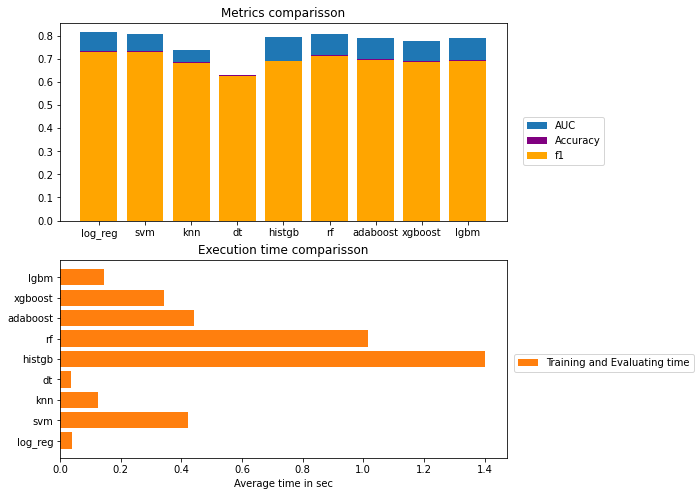

In [38]:
# Ploting the model comparison results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2, 1, 1)

ax.bar(results_df.iloc[:, 0], results_df.iloc[:, 4], label='AUC')
ax.bar(results_df.iloc[:, 0], results_df.iloc[:, 2], color='purple', label='Accuracy')
ax.bar(results_df.iloc[:, 0], results_df.iloc[:, 3], color='orange', label='f1')

ax.set_title('Metrics comparison')
ax.legend(loc='upper right', bbox_to_anchor=(1.23, 0.55))

ax = fig.add_subplot(2, 1, 2)
ax.barh(results_df.iloc[:, 0].values, results_df.iloc[:, 1], color='C1', label='Training and Evaluating time')
ax.set_title('Execution time comparisson')
ax.set_xlabel('Average time in sec')
ax.legend(loc='upper right', bbox_to_anchor=(1.43, 0.55))
plt.show()

The best model overall but not well speed-wise is support vector machine, followed by logistic regression, which is not far away and slightly faster.
We could try to tune hyperparameters of both models, in order to get a little bit beter results

## 3. Hyperparameters tuning

In [39]:
# Buildin a class for encapsulating the optuna fucntionality
class Objective(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        classifier_name = trial.suggest_categorical("classifier", ["SVC", "LogisticRegression"])

        if classifier_name == "SVC":
            svc_c = trial.suggest_float("svc_c", 1e-5, 1e3, log=True)
            svc_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']) 
            svc_degree = trial.suggest_int("degree", 2, 4, log=True)
            classifier_obj = SVC(C=svc_c, kernel=svc_kernel, degree=svc_degree, gamma="auto", random_state=SEED)
        else:
            logreg_c = trial.suggest_float("logreg_c", 1e-5, 1e3, log=True)
            logreg_solver = trial.suggest_categorical("solver", ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
            classifier_obj = LogisticRegression(C=logreg_c, solver=logreg_solver, random_state=SEED)

        score = cross_val_score(classifier_obj, self.X, self.y, cv=3)
        accuracy = score.mean()
        return accuracy

In [ ]:
#in order to skip the output of each trial
optuna.logging.set_verbosity(optuna.logging.WARNING)

# instantiating the objective and creating a study for optuna
objective = Objective(X, y)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, timeout=900, show_progress_bar=True)

In [41]:
# identifying the best model with tuned parameters
trial = study.best_trial
print(trial.value)
print(trial.params)

0.7410881801125703
{'classifier': 'LogisticRegression', 'logreg_c': 0.22286536737036564, 'solver': 'sag'}


After tuning procedure, we see, that logistic regression "won" the tuning and yields best results overall compairing with support vector machine in our case. Now the results of tuned logistic regression are better than of stock and tuned support vector machine Although the only best stock model were chosen and tuned, it could be chosen and tuned other tree based, boosting/bagging models from the model list as well and they could yield even better results after hyperparameter tuning procedure. 

In [42]:
# Creatin the model with best parameters, fiting and predicting on the test set
log_reg = LogisticRegression(C=trial.params['logreg_c'], solver=trial.params['solver'], random_state=SEED)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

LogisticRegression(C=0.22286536737036564, random_state=147, solver='sag')

In [44]:
print(classification_report(y_train, log_reg.predict(X_train)))

              precision    recall  f1-score   support

           0       0.72      0.73      0.73       547
           1       0.77      0.76      0.77       652

    accuracy                           0.75      1199
   macro avg       0.75      0.75      0.75      1199
weighted avg       0.75      0.75      0.75      1199



## 4. Tensorflow

In [46]:
# Creating an own ANN model via sublcassing from tf.keras.Model
class ANNClassifier(Model):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.dense1 = Dense(32, activation=tf.nn.relu, input_shape=(11,))
        self.dense2 = Dense(1, activation=tf.keras.activations.sigmoid)

    def call(self, x):
        x = self.dense1(x)
        return self.dense2(x)

In [47]:
# Instantiating the model
ann_classifier = ANNClassifier()

# Loading optimizer and some metrics for the model
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='training_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='training_accuracy')

test_loss = tf.keras.metrics.Mean(name='testing_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='testing_accuracy')

In [48]:
# Identifying single training and testing step 

@tf.function
def training_step(X, y, model):
    with tf.GradientTape() as tape:
        predictions = model(X, training=True)
        loss = loss_object(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y, predictions)


@tf.function
def testing_step(X, y, model):
    predictions = model(X, training=False)
    t_loss = loss_object(y, predictions)

    test_loss(t_loss)
    test_accuracy(y, predictions)

In [49]:
# Creating data for the ANN

def create_datasets(X_train, y_train, X_test, y_test):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1)
    return train_ds, test_ds


train_ds, test_ds = create_datasets(X_train, y_train, X_test, y_test)

In [63]:
# Training and testing the model in range of epochs(5)

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for X_train, y_train in train_ds:
        training_step(X_train, y_train, ann_classifier)

    for X_test, y_test in test_ds:
        testing_step(X_test, y_test, ann_classifier)

    print(f"Epoch No. {epoch + 1}",
         f"Training Loss: {train_loss.result():.3f}",
         f"Training Accuracy: {(train_accuracy.result() * 100):.3f}",
         f"Testing Loss: {test_loss.result():.3f}",
         f"Testing Accuracy: {(test_accuracy.result() * 100):.3f}")

Epoch No. 1 Training Loss: 0.484 Training Accuracy: 77.064 Testing Loss: 0.471 Testing Accuracy: 78.065
Epoch No. 2 Training Loss: 0.481 Training Accuracy: 77.231 Testing Loss: 0.467 Testing Accuracy: 78.232
Epoch No. 3 Training Loss: 0.478 Training Accuracy: 77.231 Testing Loss: 0.465 Testing Accuracy: 78.732
Epoch No. 4 Training Loss: 0.475 Training Accuracy: 77.398 Testing Loss: 0.462 Testing Accuracy: 79.233
Epoch No. 5 Training Loss: 0.472 Training Accuracy: 77.148 Testing Loss: 0.459 Testing Accuracy: 78.899
Epoch No. 6 Training Loss: 0.470 Training Accuracy: 77.231 Testing Loss: 0.456 Testing Accuracy: 78.816


In [72]:
print(classification_report(y_test, tf.math.round(ann_classifier.predict(X_test))))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74       197
           1       0.75      0.76      0.76       203

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400



In [64]:
#ann_classifier.summary()
#ann_classifier.reset_metrics()
#tf.math.round(ann_classifier.predict(X_test[:1]))

## Conlusions
- Following features are giving not the best possibility for separating data. It can be seen, that features values withen the groups are not homogenous enough.
- Some features are having very high correlation and according to the name, may be repeating each other some way, so it could be a good idea to remove some of them, by looking on feature importance of classifiers output, test different models etc. Creating additionals features may help too.
- The best model were SVM and Logistic Regression (which has become stayed the best even after hyperparamet tuning), but the neural network from the tensor flow had even better results and there is a tuning potential as well (tweaking learning rate, experimenting with learning rate decay after each epoch, etc.)